In [2]:
#pip install nilearn nibabel seaborn networkx nxviz community sklearn matplotlib plotly dash


In [3]:
# Libraries
from nilearn import datasets
import pandas as pd
from nilearn import plotting
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import resample_to_img
from sklearn.metrics import jaccard_score
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import numpy as np
import glob
#import seaborn as sns
# Network Libraries
import networkx as nx
#from nxviz import CircosPlot
import community
import plotly 
#import dash
import os
from PIL import Image
import tqdm



In [4]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas.labels=atlas.labels.tolist()
atlas_labels = [label.decode('utf-8') for label in atlas.labels]
atlas_filename=atlas.maps

In [5]:
# def load_data(subject,iter,ses):

#         # Locate the data of the first subject
#         func = f'/home/mina94/projects/rrg-glatard/mina94/fixSeed_threads/fmriprep_mca-output/iter_{iter}/{subject}/ses-{ses}/func/{subject}_ses-{ses}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
#         #template used 
#         template='/home/mina94/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz'
#         # atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
#         #atlas='/home/mina94/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_atlas-Schaefer2018_desc-100Parcels17Networks_dseg.nii.gz'
#        #maybe add this atlas feature in public env t obe accessible
#         # atlas.labels=atlas.labels.tolist()
#         # atlas_labels = [label.decode('utf-8') for label in atlas.labels]
#         return func, template

In [6]:
def compute_timeseries(sub,iter, ses): #(func,sub,iter, ses)
    func = f'/home/mina94/projects/rrg-glatard/mina94/fixSeed_threads/fmriprep_ieee-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    # func = f'/home/mina94/scratch/fixSeed_threads/fmriprep_ieee-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    fmri_img=nib.load(func)
    confounds_fn = f'/home/mina94/projects/rrg-glatard/mina94/fixSeed_threads/fmriprep_ieee-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_desc-confounds_timeseries.tsv'
    # confounds_fn = f'/home/mina94/scratch/fixSeed_threads/fmriprep_ieee-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_desc-confounds_timeseries.tsv'
    # We need to load the confounds and fill nas
    confounds = pd.read_table(confounds_fn).fillna(method='bfill')
    confounds_to_include = ['global_signal', 'csf',
                                'white_matter', 'trans_x', 'trans_y',
                                'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x_power2',
                                'trans_y_power2', 'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2']
    confounds = confounds[confounds_to_include]
    # Initialize the NiftiLabelsMasker with some standard options for preprocessing
    masker = NiftiLabelsMasker(atlas_filename, standardize=True, smoothing_fwhm=6,memory='nilearn_cache', verbose=5)
    time_series = masker.fit_transform(fmri_img, confounds)
    #plot the correlation matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # correlation_matrix[correlation_matrix<=0.005] = 0 applying threshold

    # Mask the main diagonal for visualization:
    np.fill_diagonal(correlation_matrix, 0)
    # Plot correlation matrix - note: matrix is ordered for block-like representation
    # title = f'iter_{iter}'
    # fig= plotting.plot_matrix(correlation_matrix, title=title, figure=(8,8), labels=atlas_labels,
    #                  vmax=0.8, vmin=-0.8, reorder=False);
    # Save the plot, create ses folder for each subject
    # fig.figure.savefig((f'{save_filepath}/views/{sub}/{ses}/{iter}_views.png'))
    # print(f'save the plot of {sub} for {iter} in {save_filepath}/views/{sub}/{ses}/{iter}_views.png')
    # plt.close(fig.figure)

    return time_series, correlation_matrix


In [7]:
def building_graph (correlation_matrix):
    G = nx.Graph()
    # Add nodes to the graph
    num_nodes = correlation_matrix.shape[0]
    G.add_nodes_from(range(num_nodes))
    print(f"Graph G with {num_nodes} nodes was built")
    # Add edges based on correlation matrix
    threshold = 0.05  # Adjust this threshold as needed
    #G.add_edges([(i, j, correlation_matrix[i, j] for i in ... for j in ...)])
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            #if j == i:compute_graph_measures
                #continue
            correlation = correlation_matrix[i, j]
            if abs(correlation) >= threshold:
                G.add_edge(i, j, weight=correlation)
    # Removing self-loops
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    return G

In [8]:
def compute_graph_measures(G):
    # Compute centrality
    degree_centralities = nx.degree_centrality(G)
    betweenness_centralities = nx.betweenness_centrality(G)
    eigenvector_centralities = nx.eigenvector_centrality(G)

    # Compute clustering coefficient
    clustering_coefficients = nx.clustering(G)

    # Compute shortest path lengths
    shortest_path_lengths = dict(nx.shortest_path_length(G))

    # Compute clustering coefficient
    avg_clustering_coefficient = nx.average_clustering(G)

    # Compute average shortest path length
    avg_shortest_path_length = nx.average_shortest_path_length(G)

    # Compute small-worldness
    small_worldness = avg_clustering_coefficient / avg_shortest_path_length
        # Construct the dictionary of graph metrics
    graph_metrics = {
        'degree_centralities': degree_centralities,
        'betweenness_centralities': betweenness_centralities,
        'eigenvector_centralities': eigenvector_centralities,
        'clustering_coefficients': clustering_coefficients,
        'shortest_path_lengths': shortest_path_lengths,
        'small_worldness': small_worldness
    }

    return graph_metrics
    
    # return {
    #     'degree_centralities': nx.degree_centrality(G),
    #     ...
    # }


In [9]:
# # base = 'fmriprep_mca-output'
# save_filepath='connectome_gifs'
# for sub in range (1,11): 
#         if sub < 10:
#             sub = f'sub-126BPCP02100{sub}'
#         else:
#             sub = 'sub-126BPCP021010'
#         for iter in tqdm.tqdm(range(1,11)):
#             try:
#                 func, template, confounds, atlas=load_data(sub,iter)
#                 # Plot MRI image without coordinate axes
#                 iter_dict[f'iter_{iter}'][f'{sub}']['time_series'], iter_dict[f'iter_{iter}'][f'{sub}']['correlation_matrix'] =   compute_timeseries(atlas , func,sub,iter,save_filepath)
#             except Exception as e:
#                 print(e)
#                 continue
#         frames = [Image.open(f'{save_filepath}/views/{sub}/{image}') for image in os.listdir(f'{save_filepath}/views/{sub}')]
#         frame_one = frames[0]

#         frame_one.save(f"{save_filepath}/{sub}.gif", format="GIF", append_images=frames,save_all=True, duration=200, loop=0)
#         print('Gif of one subject is made')


In [10]:
# iter_dict={'iter_1':{}, 'iter_2': {}, 'iter_3': {},'iter_4': {},'iter_5': {},'iter_6': {},'iter_7': {},'iter_8': {},'iter_9': {},'iter_10': {}}
#iter_dict = { f'iter_{i}': {} for i in range(1, 11)}

In [11]:
#creating dictionary for each subject that include number of MCA runs dictonary of features, maybe for each session or run mak differen dictionary
"""
{'sub-126BPCP021007': {'iter_1': {},'iter_2': {},'iter_3': {},'iter_4': {}, 'iter_5': {}, 'iter_6': {}, 'iter_7': {}, 'iter_8': {},  'iter_9': {},  'iter_10': {}},
 'sub-126BPCP021009': {'iter_1': {}, 'iter_2': {}, 'iter_3': {}, 'iter_4': {}, 'iter_5': {}, 'iter_6': {}, 'iter_7': {}, 'iter_8': {}, 'iter_9': {}, 'iter_10': {}},
 'sub-126BPCP021003': {'iter_1': {}, 'iter_2': {}, 'iter_3': {}, 'iter_4': {}, ....
 }
"""
def create_subdict(base):
     sublist=[]
     for subj in glob.glob(f'{base}/iter_1/sub-*'):
          if subj.endswith('.html'):
            continue  # Skip elements that end with .HTML
          sub_id = os.path.basename(subj)
          sublist.append(sub_id)
     #Initialize the outer dictionary for each subject
     iter_names = ['iter_1', 'iter_2', 'iter_3', 'iter_4', 'iter_5', 'iter_6', 'iter_7', 'iter_8', 'iter_9', 'iter_10']

     # Initialize the main dictionary
     iter_dict = {subject: {iter_name: {} for iter_name in iter_names} for subject in sublist}      

     return iter_dict    


In [12]:
subdict_ses1=create_subdict('/home/mina94/projects/rrg-glatard/mina94/fixSeed_threads/fmriprep_mca-output')

In [15]:


def compute_metrics_forall(subdict,ses):
    for sub, iter in subdict.items():
        for iters in iter.items():
            iters=iters[0]
            i=int(iters.split('_')[1])
            # func, template, confounds=load_data(sub,i, ses)
            subdict[sub][iters]['time_series'], subdict[sub][iters]['correlation_matrix'] =   compute_timeseries(sub, i, ses)
            subdict[sub][iters]['graph']= building_graph(subdict[sub][iters]['correlation_matrix'])
            subdict[sub][iters]['graph_metrics']= compute_graph_measures(subdict[sub][iters]['graph'])
                                                              
compute_metrics_forall(subdict_ses1,1)

/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]51.3s, 0.9min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]5.0s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]8.3s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.3s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.2s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]4.8s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.7s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.0s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]4.6s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.5s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]4.2s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.8s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]4.6s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.5s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]8.1s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.3s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]6.4s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]7.2s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]5.9s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]7.2s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]18.7s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]9.8s, 0.2min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.7s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]15.6s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.4s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]13.4s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.4s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]15.2s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]11.5s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.1s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.8s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]7.9s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.4s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.6s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.5s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.6s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]5.6s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 3.4s, 0.1min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]23.1s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1b20bb2910>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b20efbb90>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 2.46s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1b21f49f90>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b21933c10>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 1.91s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae0e0c610>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b21324510>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 1.86s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae0e5a910>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b21a67dd0>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 0.76s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae0c08250>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b211a5690>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1b2546cdd0>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b21ebdad0>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 1.66s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae0d152d0>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b21752a10>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 1.12s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1b23d7ba90>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b22db6890>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae07e2990>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1ae0af3e10>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 1.08s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1b23642310>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b22215b90>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 0.58s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1b26c23290>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b21a98e10>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 1.49s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae04d8690>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1ae10c7090>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae03cc950>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b22fe4390>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 4.72s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae041c610>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b214193d0>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 5.45s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae0e0ffd0>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1ae0a14050>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 3.02s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae02a8590>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b21699050>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 3.69s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae0516650>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b2395b650>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 4.24s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae0098290>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1ae06e63d0>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 4.02s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1adff92d50>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b232c5b10>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 2.68s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1ae00985d0>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f1b21f7bc10>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

/lustre07/scratch/mina94/fixSeed_threads/myenv2/lib/python3.11/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 6.36s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Graph G with 100 nodes was built


In [ ]:
import json

# Save dictionary to a JSON file
file_path = '/home/mina94/projects/rrg-glatard/mina94/fixSeed_threads/Notebook/subdict_ses1.json'
with open(file_path, 'w') as f:
    json.dump(subdict_ses1, f)

In [ ]:
subdict_ses1['sub-126BPCP021010']['iter_6']['graph_metrics']['eigenvector_centralities']

{0: 0.08709950146611495,
 1: 0.10485792348814932,
 2: 0.09891505716354454,
 3: 0.10039093339817172,
 4: 0.0938424875767103,
 5: 0.09858371860005417,
 6: 0.10667759225698487,
 7: 0.1042836546123957,
 8: 0.10694170276344483,
 9: 0.10005788358841369,
 10: 0.09584898412543619,
 11: 0.0991349677862472,
 12: 0.09678522954857904,
 13: 0.0982354679047375,
 14: 0.09616395228287218,
 15: 0.10206715943711217,
 16: 0.09639138249479923,
 17: 0.10099869446083207,
 18: 0.09746519479280778,
 19: 0.09832545587488649,
 20: 0.10541052313434535,
 21: 0.09993169394816677,
 22: 0.10324438199143351,
 23: 0.10683128543745625,
 24: 0.10005695183041749,
 25: 0.09926516487795904,
 26: 0.10220689295677908,
 27: 0.09512452989557577,
 28: 0.09648926842377578,
 29: 0.09836894632557198,
 30: 0.09411385217391713,
 31: 0.0849439803616474,
 32: 0.1005105246770555,
 33: 0.09978724855074422,
 34: 0.09531677264834446,
 35: 0.1068435167256227,
 36: 0.09355041997923293,
 37: 0.10773704274237537,
 38: 0.09184291979716634,
 39

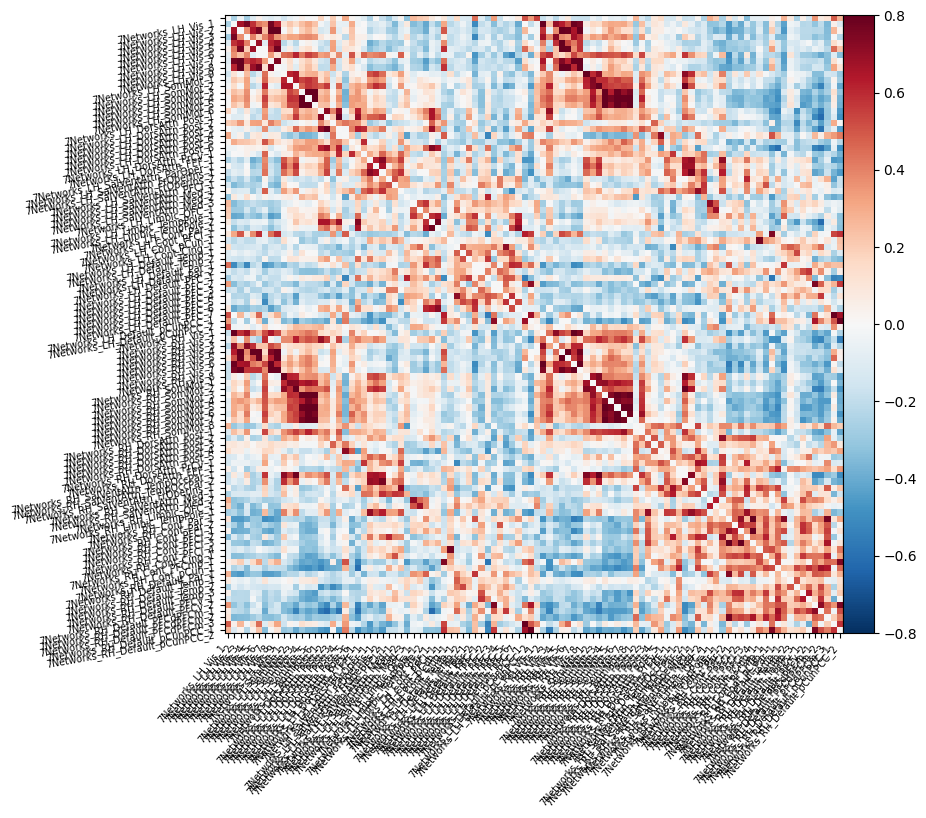

In [ ]:
#figure the correlation matrix
correlation_matrix=subdict_ses1['sub-126BPCP021010']['iter_6']['correlation_matrix']
# correlation_matrix_copy =  correlation_matrix.copy()
# correlation_matrix_copy[correlation_matrix_copy<0.005]=0 
plotting.plot_matrix(correlation_matrix,figure=(8,8),labels=atlas_labels,
                     vmax=0.8, vmin=-0.8, reorder=False);


In [ ]:
subdict_ses1['sub-126BPCP021001']['iter_1']['graph_metrics']['shortest_path_lengths']

1.1177777777777778

In [16]:

for sub, iter in subdict_ses1.items():
    subdict_ses1[sub]['std_metric'] = {
        'std_degree': [],
        'std_betweeness': [],
        'std_eigen': [],
        'std_clusteringCoefficient': [],
        'std_shortest_path_lengths':[]
                                          }
    for item , val in iter.items(): 
        if "iter" in item:
            std_degree=  np.std(list(subdict_ses1[sub][item]['graph_metrics']['degree_centralities'].values()))
            std_betweeness=np.std(list(subdict_ses1[sub][item]['graph_metrics']['betweenness_centralities'].values())) 
            std_eigen =np.std(list(subdict_ses1[sub][item]['graph_metrics']['eigenvector_centralities'].values())) 
            std_clusteringCoefficient = np.std(list(subdict_ses1[sub][item]['graph_metrics']['clustering_coefficients'].values()))
            # print(f'The std value of metric for subject {sub} and iteration {item} : std_degree: {std_degree}, std_betweeness: {std_betweeness}, std_eigen :{std_eigen}, std_clustering_coefficient:{std_clusteringCoefficient}')    
            subdict_ses1[sub]['std_metric']['std_degree'].append(std_degree)
            subdict_ses1[sub]['std_metric']['std_betweeness'].append(std_betweeness)
            subdict_ses1[sub]['std_metric']['std_eigen'].append(std_eigen)
            subdict_ses1[sub]['std_metric']['std_clusteringCoefficient'].append(std_clusteringCoefficient)

In [ ]:
print(subdict_ses1['sub-126BPCP021001']['std_metric']['std_degree'])

[0.05974506258098519, 0.06037836013688266, 0.0588607275388559, 0.05828904261112528, 0.05956205164467427, 0.05954937401961457, 0.06002244249190134, 0.05715279695496568, 0.0590109966423375, 0.05846382274136478]


In [ ]:
# df=pd.DataFrame.from_dict(subdict_ses1['sub-126BPCP021001']['std_metric'])
# long_df = pd.melt(df)
# long_df

In [ ]:
# pip install seaborn

In [19]:
IEEE_metric = { f'sub-126BPCP021{i:03}': {} for i in range(1, 11)}

for i in range (1,11):
    sub= f'sub-126BPCP021{i:03}'
    print (sub)
    IEEE_metric[sub] = {}
    IEEE_metric[sub]['time_series'], IEEE_metric[sub]['correlation_matrix'] =   compute_timeseries(sub, 1,1)
    IEEE_metric[sub]['graph']= building_graph(IEEE_metric[sub]['correlation_matrix'])
    IEEE_metric[sub]['graph_metrics']= compute_graph_measures(IEEE_metric[sub]['graph'])

sub-126BPCP021001


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.9s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021002


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]78.9s, 1.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 1.4s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021003


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]8.6s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 2.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021004


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]34.6s, 0.6min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.8s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021005


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]222.9s, 3.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 7.7s, 0.1min
Graph G with 100 nodes was built
sub-126BPCP021006


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]5.4s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021007


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]11.4s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.3s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021008


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]122.4s, 2.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 1.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021009


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]30.7s, 0.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021010


/tmp/ipykernel_1708383/3711351114.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]23.4s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


In [ ]:
# for sub, iter in IEEE_metric.items():
#         IEEE_metric[sub]['std_metric'] = {
#         'std_degree': [],
#         'std_betweeness': [],
#         'std_eigen': [],
#         'std_clusteringCoefficient': []}
#         IEEE_metric[sub]['std_metric']['std_degree']=  np.std(list(IEEE_metric[sub]['graph_metrics']['degree_centralities'].values()))
#         IEEE_metric[sub]['std_metric']['std_betweeness']=np.std(list(IEEE_metric[sub]['graph_metrics']['betweenness_centralities'].values())) 
#         IEEE_metric[sub]['std_metric']['std_eigen'] =np.std(list(IEEE_metric[sub]['graph_metrics']['eigenvector_centralities'].values())) 
#         IEEE_metric[sub]['std_metric']['std_clusteringCoefficient'] = np.std(list(IEEE_metric[sub]['graph_metrics']['clustering_coefficients'].values()))
#         print(f'The std value of metric for subject {sub}: std_degree: {std_degree}, std_betweeness: {std_betweeness}, std_eigen :{std_eigen}, std_clustering_coefficient:{std_clusteringCoefficient}')    
        

In [20]:

# Loop over subjects and iterations
for sub, metrics in IEEE_metric.items():
    # Initialize the std_metric dictionary
    std_metrics = {
        'std_degree': np.std(list(metrics['graph_metrics']['degree_centralities'].values())),
        'std_betweeness': np.std(list(metrics['graph_metrics']['betweenness_centralities'].values())),
        'std_eigen': np.std(list(metrics['graph_metrics']['eigenvector_centralities'].values())),
        'std_clusteringCoefficient': np.std(list(metrics['graph_metrics']['clustering_coefficients'].values()))
    }

    # Update the IEEE_metric dictionary with computed std_metrics
    IEEE_metric[sub]['std_metric'] = std_metrics

    # Print the results for each subject
    print(f"The std value of metric for subject {sub}: "
          f"std_degree: {std_metrics['std_degree']}, "
          f"std_betweeness: {std_metrics['std_betweeness']}, "
          f"std_eigen: {std_metrics['std_eigen']}, "
          f"std_clustering_coefficient: {std_metrics['std_clusteringCoefficient']}")

The std value of metric for subject sub-126BPCP021001: std_degree: 0.05974506258098519, std_betweeness: 0.00018481300270800679, std_eigen: 0.0067225260205426044, std_clustering_coefficient: 0.007014913022696978
The std value of metric for subject sub-126BPCP021002: std_degree: 0.06614704134321793, std_betweeness: 0.0002780004078876756, std_eigen: 0.00760799501503572, std_clustering_coefficient: 0.008640515418257739
The std value of metric for subject sub-126BPCP021003: std_degree: 0.052736173249324385, std_betweeness: 0.0002010800006472423, std_eigen: 0.0061642615601705635, std_clustering_coefficient: 0.005646410574149304
The std value of metric for subject sub-126BPCP021004: std_degree: 0.05945883900105632, std_betweeness: 0.00020023148357040037, std_eigen: 0.006774496153015136, std_clustering_coefficient: 0.007071824984271665
The std value of metric for subject sub-126BPCP021005: std_degree: 0.06355325661911604, std_betweeness: 0.00023192712463245113, std_eigen: 0.007498313739654725,

In [ ]:
subdict_ses1['sub-126BPCP021001']['']

KeyError: ''

In [ ]:
# # Initialize empty cumulative metric values
# # Define the number of subjects, iterations, and metrics
# num_subjects = 10  # Replace with the actual number of subjects
# num_iterations = 10
# metrics = ['betweenness_centralities', 'clustering_coefficients', 'degree_centralities', 'eigenvector_centralities','shortest_path_lengths']

# # Create the nested dictionary
# dict_4statistic_MCA  = {
#     f'subject_{i+1}': {f'iteration_{j+1}': {metric: [] for metric in metrics} for j in range(num_iterations)}
#     for i in range(num_subjects)
# }

# # Print the dictionary to verify its structure
# import pprint
# pprint.pprint(dict_4statistic_MCA 
# )

{'subject_1': {'iteration_1': {'betweenness_centralities': [],
                               'clustering_coefficients': [],
                               'degree_centralities': [],
                               'eigenvector_centralities': []},
               'iteration_10': {'betweenness_centralities': [],
                                'clustering_coefficients': [],
                                'degree_centralities': [],
                                'eigenvector_centralities': []},
               'iteration_2': {'betweenness_centralities': [],
                               'clustering_coefficients': [],
                               'degree_centralities': [],
                               'eigenvector_centralities': []},
               'iteration_3': {'betweenness_centralities': [],
                               'clustering_coefficients': [],
                               'degree_centralities': [],
                               'eigenvector_centralities': []},
        

In [45]:
print(type(subdict_ses1['sub-126BPCP021001']['iter_1']['correlation_matrix']))

<class 'numpy.ndarray'>


In [40]:
# Convert the NumPy array to a list
time_series_list = dict_4statistic_MCA['sub-126BPCP021001']['iter_1']['time_series'].tolist()[0]
print(time_series_list)
# Function to calculate the shape of a nested list
# def shape(lst):
#     if isinstance(lst, list):
#         return [len(lst)] + shape(lst[0])
#     return []

# # Get the shape of the list
# list_shape = shape(time_series_list)

# print(f"Shape of the list: {list_shape}")

[0.49396055936813354, -0.1896374672651291, -0.8472506403923035, 0.567064642906189, -0.35037901997566223, -0.4790007472038269, 1.0927543640136719, 0.7044004797935486, 0.1355873942375183, 0.4649951159954071, 0.4320458769798279, 0.6877809762954712, 0.19407044351100922, 0.7993020415306091, 0.5027602910995483, 0.009318831376731396, -1.1866083145141602, -1.011949062347412, -0.440894216299057, 0.022425470873713493, 0.26919886469841003, -0.5729917883872986, 0.49589669704437256, 0.010475331917405128, -1.5580579042434692, -0.6233002543449402, -0.4385907053947449, -0.3178580105304718, -0.3748329281806946, 1.1430165767669678, 0.01343271043151617, -0.20313608646392822, -0.2378406673669815, -1.367512822151184, -0.9707516431808472, -0.9684574604034424, -0.8855804204940796, 0.6424837112426758, 0.5082475543022156, 0.3325996696949005, -0.5562205910682678, -0.5913810729980469, -0.3353210985660553, 0.8091933131217957, 0.16835688054561615, 0.37247928977012634, -1.0565990209579468, 0.05909368768334389, 0.58

In [49]:
import copy
import json
import numpy as np

# Create a deep copy of subdict_ses1
dict_4statistic_MCA = copy.deepcopy(subdict_ses1)

# List of keys to delete
keys_to_delete_secondlevel = ['graph']

# Delete specified second-level keys from each iteration within each subject
for subject, iterations in dict_4statistic_MCA.items():
    for iteration_key, iteration in iterations.items():
        for key in keys_to_delete_secondlevel:
            iteration.pop(key, None)
        if 'correlation_matrix' in iteration:
            iteration['correlation_matrix'] = iteration['correlation_matrix'].tolist()
        if 'time_series' in iteration:
            iteration['time_series'] = iteration['time_series'].tolist()

# Create a deep copy of IEEE_metric
dict_4statistic_IEEE = copy.deepcopy(IEEE_metric)

# List of keys to delete
keys_to_delete_firstlevel = ['graph']

# Delete specified first-level keys from each subject
for subject, iterations in dict_4statistic_IEEE.items():
    for key in keys_to_delete_firstlevel:
        iterations.pop(key, None)
    if 'correlation_matrix' in iterations:
        iterations['correlation_matrix'] = iterations['correlation_matrix'].tolist()
    if 'time_series' in iterations:
        iterations['time_series'] = iterations['time_series'].tolist()

# Save dictionary to a JSON file
file_path = 'dict_4statistic_MCA.json'
with open(file_path, 'w') as f:
    json.dump(dict_4statistic_MCA, f)

# Save dictionary to a JSON file
file_path = 'dict_4statistic_IEEE.json'
with open(file_path, 'w') as g:
    json.dump(dict_4statistic_IEEE, g)


In [51]:
import json

# Define the file path to your JSON file
file_path = '/home/mina94/projects/rrg-glatard/mina94/fixSeed_threads/Notebook/dict_4statistic_MCA.json'

# Open the JSON file and load its contents into a dictionary
with open(file_path, 'r') as f:
    dict_4statistic_MCA_open = json.load(f)



In [53]:
dict_4statistic_MCA_open['sub-126BPCP021001']['iter_1']['graph_metrics']['betweenness_centralities']

{'0': 0.0010877339989224005,
 '1': 0.0012640901210282318,
 '2': 0.001175125293724069,
 '3': 0.0010173494505506114,
 '4': 0.0011392874864016504,
 '5': 0.001024407995933227,
 '6': 0.0011725718677608004,
 '7': 0.0011581788094886818,
 '8': 0.0012577158731827305,
 '9': 0.0008295768947936418,
 '10': 0.0011778448942770772,
 '11': 0.0012000754733556011,
 '12': 0.0009923675878580366,
 '13': 0.001279948721204732,
 '14': 0.0012007401452817509,
 '15': 0.0014283727358905616,
 '16': 0.0013726788170820182,
 '17': 0.0008598173140168432,
 '18': 0.0014092000721489452,
 '19': 0.0012421276825324763,
 '20': 0.0013208968166328512,
 '21': 0.0014703893119818261,
 '22': 0.001189926554705609,
 '23': 0.0011792115303092018,
 '24': 0.0010041643302092175,
 '25': 0.001279085848199715,
 '26': 0.0013900708356844682,
 '27': 0.0010379759011391071,
 '28': 0.0014832219057798932,
 '29': 0.0011014061225336333,
 '30': 0.0012530550145813317,
 '31': 0.0012664480287913745,
 '32': 0.0010104753369066465,
 '33': 0.0008720070981717

In [ ]:
subdict_ses1['sub-126BPCP021007']['iter_1']['graph_metrics']['degree_centralities']

{0: 0.7575757575757577,
 1: 0.8282828282828284,
 2: 0.8181818181818182,
 3: 0.7171717171717172,
 4: 0.8686868686868687,
 5: 0.888888888888889,
 6: 0.8484848484848485,
 7: 0.8585858585858587,
 8: 0.8282828282828284,
 9: 0.8181818181818182,
 10: 0.8282828282828284,
 11: 0.8686868686868687,
 12: 0.8585858585858587,
 13: 0.8787878787878789,
 14: 0.8080808080808082,
 15: 0.9090909090909092,
 16: 0.8181818181818182,
 17: 0.9292929292929294,
 18: 0.8484848484848485,
 19: 0.8989898989898991,
 20: 0.8989898989898991,
 21: 0.8585858585858587,
 22: 0.8989898989898991,
 23: 0.8484848484848485,
 24: 0.7575757575757577,
 25: 0.8585858585858587,
 26: 0.888888888888889,
 27: 0.8484848484848485,
 28: 0.8989898989898991,
 29: 0.8484848484848485,
 30: 0.7474747474747475,
 31: 0.787878787878788,
 32: 0.9393939393939394,
 33: 0.8383838383838385,
 34: 0.9292929292929294,
 35: 0.9494949494949496,
 36: 0.8989898989898991,
 37: 0.8686868686868687,
 38: 0.8484848484848485,
 39: 0.8686868686868687,
 40: 0.929292

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go


# Initialize Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Interactive Plotly Histograms"),
    html.Div([
        dcc.Dropdown(
            id='subject-dropdown',
            options=[{'label': subject, 'value': subject} for subject in dict_4statistic_MCA.keys()],
            value=list(dict_4statistic_MCA.keys())[0],
            style={'width': '48%', 'display': 'inline-block'}
        ),
        dcc.Dropdown(
            id='iteration-dropdown',
            style={'width': '48%', 'display': 'inline-block'}
        )
    ]),
    dcc.Graph(id='histogram-plot')
])

# Callback to update iteration dropdown based on selected subject
@app.callback(
    Output('iteration-dropdown', 'options'),
    [Input('subject-dropdown', 'value')]
)
def set_iteration_options(selected_subject):
    return [{'label': iteration, 'value': iteration} for iteration in dict_4statistic_MCA[selected_subject].keys()]

# Callback to update iteration dropdown value based on selected subject
@app.callback(
    Output('iteration-dropdown', 'value'),
    [Input('iteration-dropdown', 'options')]
)
def set_iteration_value(available_options):
    return available_options[0]['value'] if available_options else None

# Callback to update the plot based on selected subject and iteration
@app.callback(
    Output('histogram-plot', 'figure'),
    [Input('subject-dropdown', 'value'),
     Input('iteration-dropdown', 'value')]
)
def update_plot(selected_subject, selected_iteration):
    metrics = dict_4statistic_MCA[selected_subject][selected_iteration]
    
    fig = go.Figure()

    for metric_name, metric_values in metrics.items():
        fig.add_trace(go.Histogram(
            x=metric_values,
            name=metric_name,
            opacity=0.75
        ))

    fig.update_layout(
        title=f'Histograms for {selected_subject} - {selected_iteration}',
        xaxis_title='Value',
        yaxis_title='Count',
        barmode='overlay',
        bargap=0.1,
        bargroupgap=0.2
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)


In [ ]:
# Initialize empty cumulative metric values
cumulative_metric_values = {
    'betweenness_centralities': [],
    'clustering_coefficients': [],
    'degree_centralities': [],
    'eigenvector_centralities': []
}

# Iterate over subjects and items
for sub, iter in subdict_ses1.items():
    for item, val in iter.items():
        if "iter" in item:
            print(sub,item)
            betweenness_centralities = list(subdict_ses1[sub][item]['graph_metrics']['betweenness_centralities'].values())
            clustering_coefficients = list(subdict_ses1[sub][item]['graph_metrics']['clustering_coefficients'].values())
            degree_centralities = list(subdict_ses1[sub][item]['graph_metrics']['degree_centralities'].values())
            eigenvector_centralities = list(subdict_ses1[sub][item]['graph_metrics']['eigenvector_centralities'].values())

            # Accumulate values for each metric
            cumulative_metric_values['betweenness_centralities'].extend(
                betweenness_centralities
            )
            cumulative_metric_values['clustering_coefficients'].extend(
                clustering_coefficients
            )
            cumulative_metric_values['degree_centralities'].extend(
                degree_centralities
            )
            cumulative_metric_values['eigenvector_centralities'].extend(
                eigenvector_centralities
            )



df = pd.DataFrame(cumulative_metric_values)

# Print the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv('/home/mina94/projects/rrg-glatard/mina94/fixSeed_threads/cumulative_metrics_MCA.csv', index=False)



sub-126BPCP021007 iter_1
sub-126BPCP021007 iter_2
sub-126BPCP021007 iter_3
sub-126BPCP021007 iter_4
sub-126BPCP021007 iter_5
sub-126BPCP021007 iter_6
sub-126BPCP021007 iter_7
sub-126BPCP021007 iter_8
sub-126BPCP021007 iter_9
sub-126BPCP021007 iter_10
sub-126BPCP021009 iter_1
sub-126BPCP021009 iter_2
sub-126BPCP021009 iter_3
sub-126BPCP021009 iter_4
sub-126BPCP021009 iter_5
sub-126BPCP021009 iter_6
sub-126BPCP021009 iter_7
sub-126BPCP021009 iter_8
sub-126BPCP021009 iter_9
sub-126BPCP021009 iter_10
sub-126BPCP021003 iter_1
sub-126BPCP021003 iter_2
sub-126BPCP021003 iter_3
sub-126BPCP021003 iter_4
sub-126BPCP021003 iter_5
sub-126BPCP021003 iter_6
sub-126BPCP021003 iter_7
sub-126BPCP021003 iter_8
sub-126BPCP021003 iter_9
sub-126BPCP021003 iter_10
sub-126BPCP021010 iter_1
sub-126BPCP021010 iter_2
sub-126BPCP021010 iter_3
sub-126BPCP021010 iter_4
sub-126BPCP021010 iter_5
sub-126BPCP021010 iter_6
sub-126BPCP021010 iter_7
sub-126BPCP021010 iter_8
sub-126BPCP021010 iter_9
sub-126BPCP021010 iter

In [ ]:
list(subdict_ses1['sub-126BPCP021007']['iter_1']['graph_metrics']['betweenness_centralities'].values())

[0.0009915123135232288,
 0.0011558898963222473,
 0.0011187381740097653,
 0.000849984049925718,
 0.0014153961351071355,
 0.0014966568169820411,
 0.001196028521515104,
 0.0013355869088382626,
 0.0012079117870280175,
 0.0009819852774778839,
 0.0011719857432213804,
 0.0012722516469237434,
 0.0012681329845370764,
 0.0014181977701533152,
 0.0010651255187360932,
 0.001662590840639755,
 0.001088047063822588,
 0.0016429731950857258,
 0.0012442777219831636,
 0.0014522320496283864,
 0.0015072414021416647,
 0.0013934646534320358,
 0.0016275486589557885,
 0.0012072248718257158,
 0.000989709004527449,
 0.001278837401137347,
 0.0015569399269384366,
 0.0012948409185354478,
 0.001438696343963083,
 0.0013998048376062063,
 0.0010645653717463567,
 0.0011907354256344624,
 0.0017145911589243365,
 0.0014376992457365058,
 0.0016048547856382161,
 0.0017930464459114102,
 0.0014225529493194131,
 0.0014378408699852667,
 0.001313756175402767,
 0.001374491027815812,
 0.0015525078887912412,
 0.0016305674555870012,
 

In [ ]:
# Initialize empty cumulative metric values
cumulative_metric_values_IEEE = {
    'betweenness_centralities': [],
    'clustering_coefficients': [],
    'degree_centralities': [],
    'eigenvector_centralities': []
}
for sub, metric in IEEE_metric.items(): 
    for iter in range (1,11):
                        # Accumulate values for each metric
            cumulative_metric_values_IEEE['betweenness_centralities'].extend(
                list(metric['graph_metrics']['betweenness_centralities'].values())
            )
            cumulative_metric_values_IEEE['clustering_coefficients'].extend(
                list(metric['graph_metrics']['clustering_coefficients'].values())
            )
            cumulative_metric_values_IEEE['degree_centralities'].extend(
                list(metric['graph_metrics']['degree_centralities'].values())
            )
            cumulative_metric_values_IEEE['eigenvector_centralities'].extend(
                list(metric['graph_metrics']['eigenvector_centralities'].values())
            )

df_IEEE = pd.DataFrame(cumulative_metric_values_IEEE)

# Print the DataFrame
df_IEEE

# Save the DataFrame to a CSV file
df.to_csv('/home/mina94/projects/rrg-glatard/mina94/fixSeed_threads/cumulative_metrics_IEEE.csv', index=False)
print (df_IEEE['betweenness_centralities'].iloc[0], df_IEEE['betweenness_centralities'].iloc[100] )


0.0010877339989224005 0.0010877339989224005


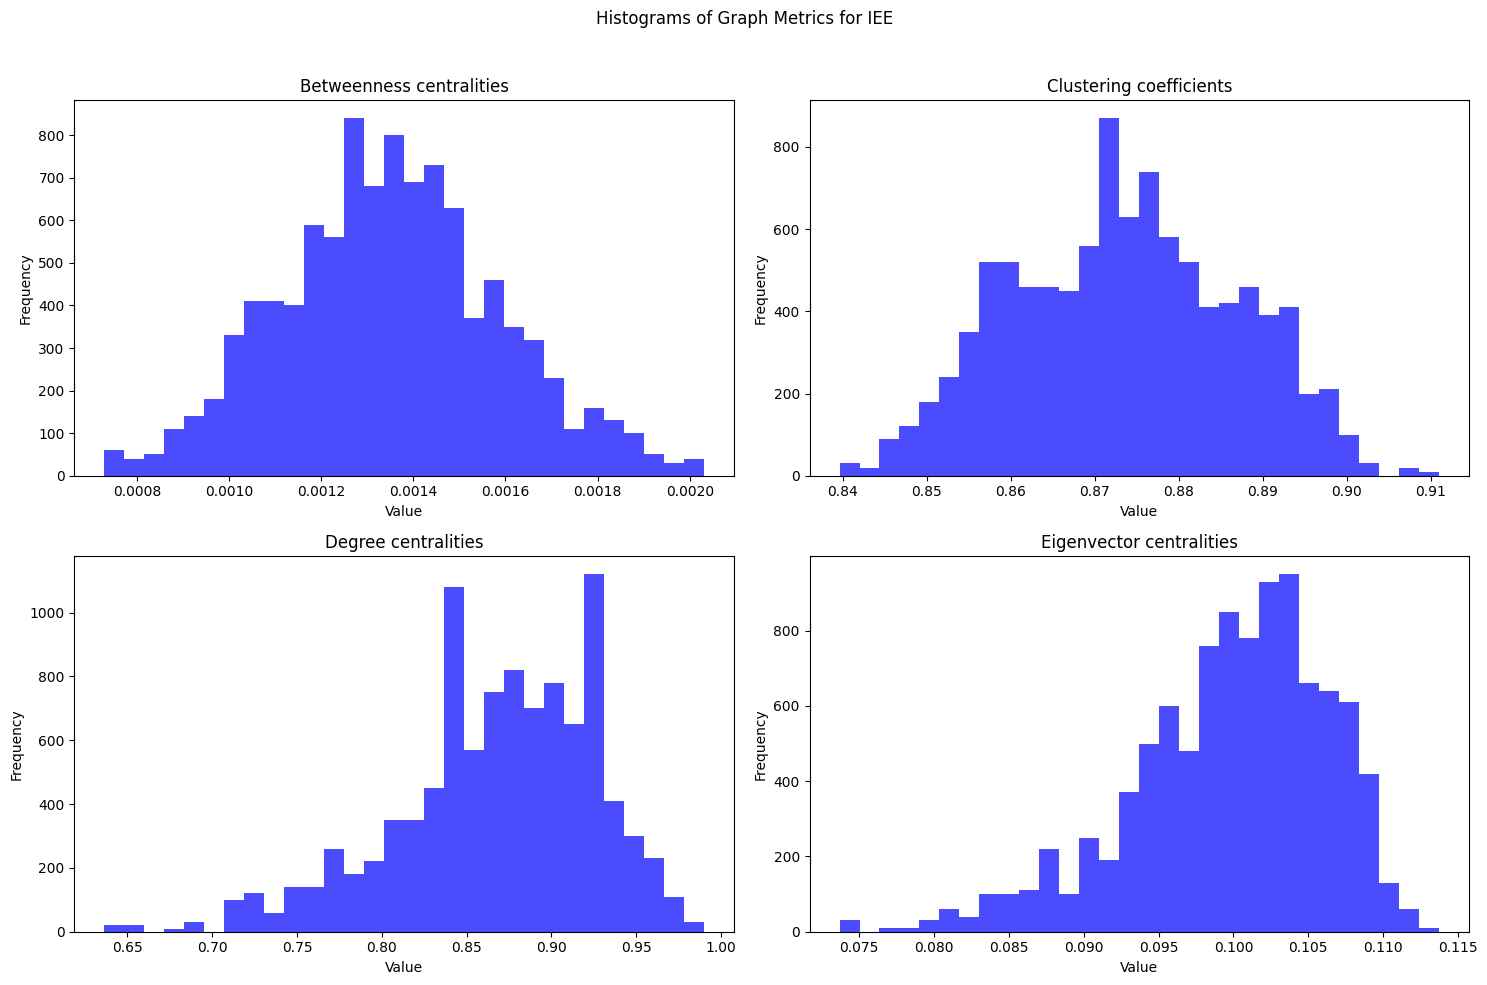

In [ ]:
# Plot histograms for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Histograms of Graph Metrics for IEE')

# Define the metrics and their positions in the subplot
metrics = ['betweenness_centralities', 'clustering_coefficients', 'degree_centralities', 'eigenvector_centralities']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Iterate over the metrics and plot each histogram
for metric, pos in zip(metrics, positions):
    axes[pos[0], pos[1]].hist(cumulative_metric_values_IEEE[metric], bins=30, alpha=0.7, color='blue')
    axes[pos[0], pos[1]].set_title(metric.replace('_', ' ').capitalize())
    axes[pos[0], pos[1]].set_xlabel('Value')
    axes[pos[0], pos[1]].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

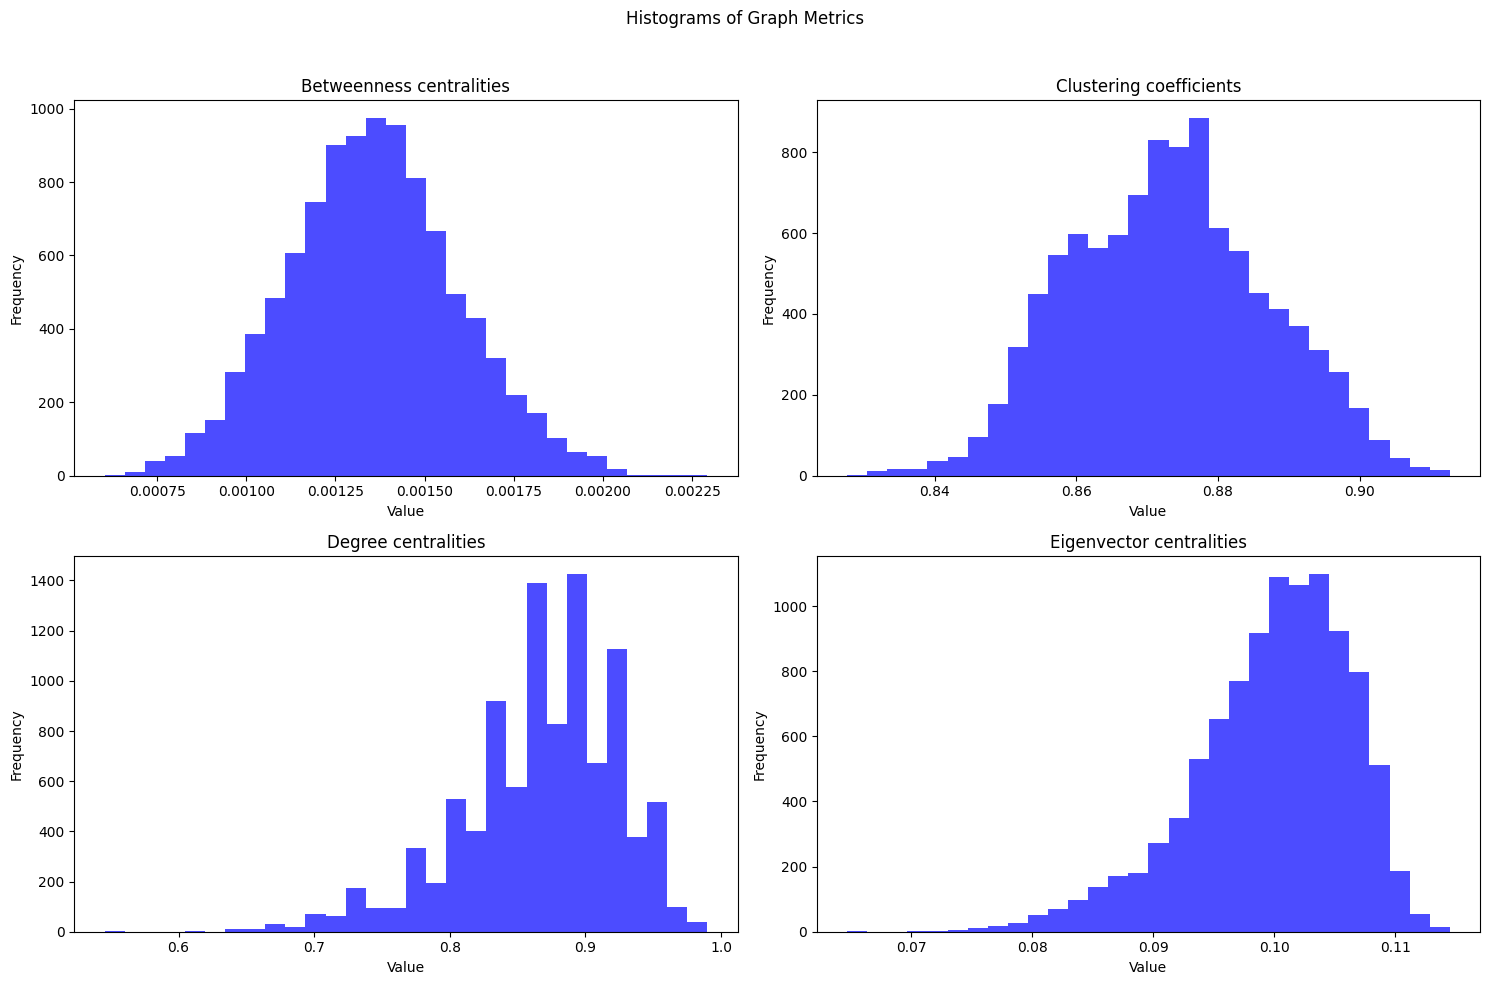

In [ ]:
# Plot histograms for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Histograms of Graph Metrics for MCA')

# Define the metrics and their positions in the subplot
metrics = ['betweenness_centralities', 'clustering_coefficients', 'degree_centralities', 'eigenvector_centralities']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Iterate over the metrics and plot each histogram
for metric, pos in zip(metrics, positions):
    axes[pos[0], pos[1]].hist(cumulative_metric_values[metric], bins=30, alpha=0.7, color='blue')
    axes[pos[0], pos[1]].set_title(metric.replace('_', ' ').capitalize())
    axes[pos[0], pos[1]].set_xlabel('Value')
    axes[pos[0], pos[1]].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

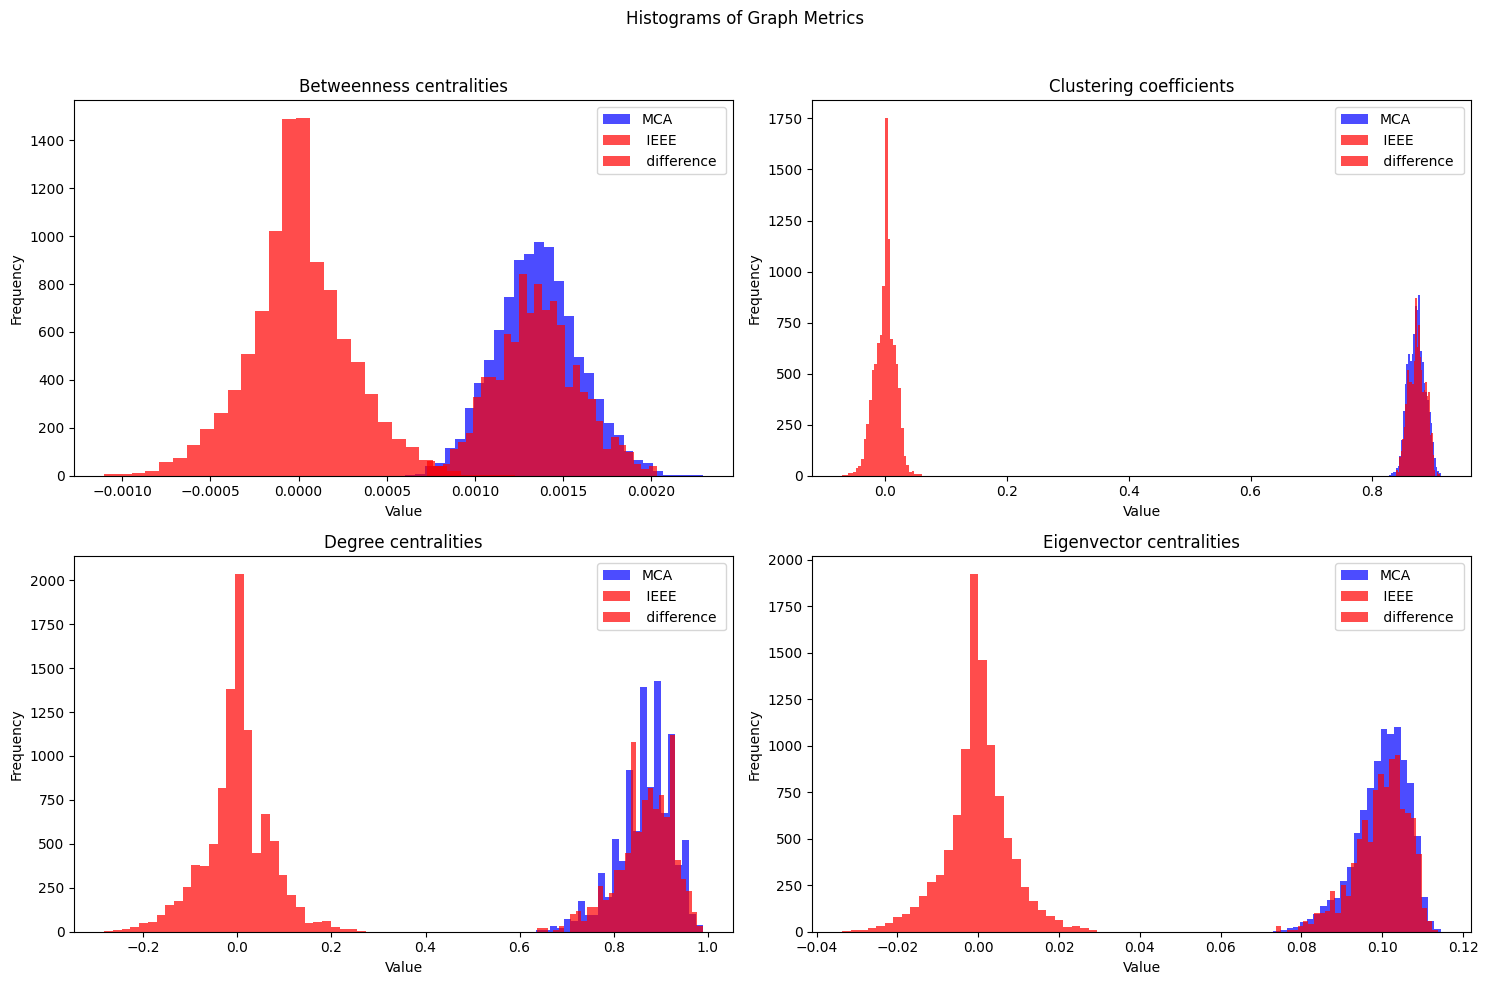

In [ ]:
# Plot histograms for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Histograms of Graph Metrics')

# Define the metrics and their positions in the subplot
metrics = ['betweenness_centralities', 'clustering_coefficients', 'degree_centralities', 'eigenvector_centralities']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Iterate over the metrics and plot each histogram for both datasets
for metric, pos in zip(metrics, positions):
    axes[pos[0], pos[1]].hist(cumulative_metric_values[metric], bins=30, alpha=0.7, color='blue', label='MCA')
    axes[pos[0], pos[1]].hist(cumulative_metric_values_IEEE[metric], bins=30, alpha=0.7, color='red', label=' IEEE ')
    axes[pos[0], pos[1]].hist(MCA_IEEE[metric], bins=30, alpha=0.7, color='red', label=' difference ')

    axes[pos[0], pos[1]].set_title(metric.replace('_', ' ').capitalize())
    axes[pos[0], pos[1]].set_xlabel('Value')
    axes[pos[0], pos[1]].set_ylabel('Frequency')
    axes[pos[0], pos[1]].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
MCA_IEEE

{}

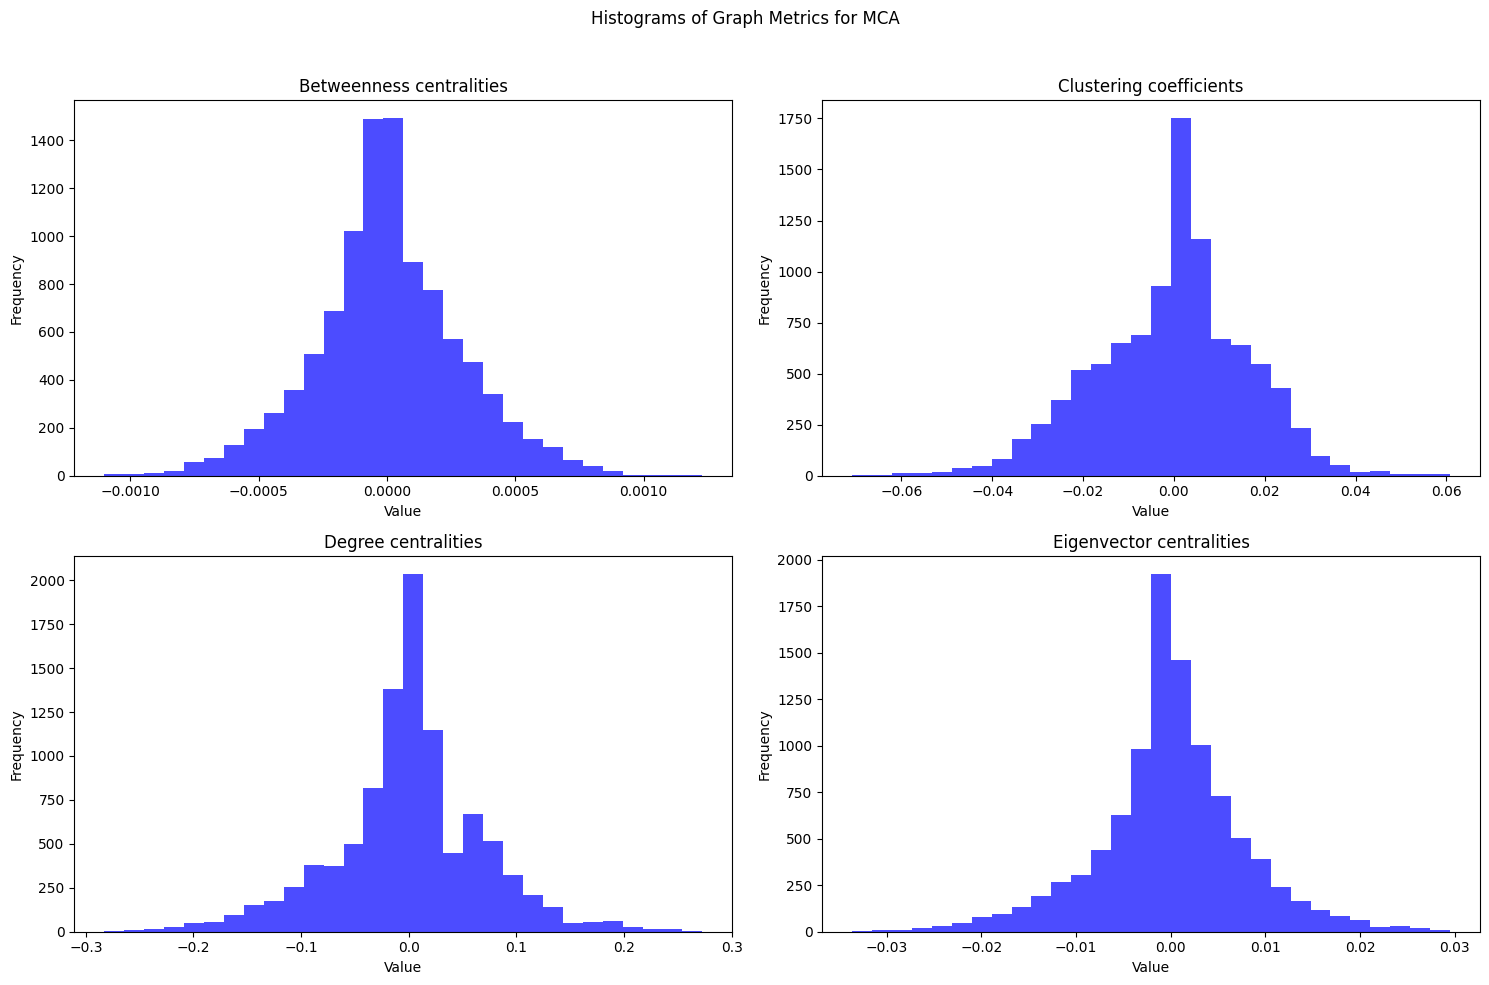

In [ ]:
df1 = pd.DataFrame(cumulative_metric_values)
df2 = pd.DataFrame(cumulative_metric_values_IEEE)
MCA_IEEE=df1-df2
# Plot histograms for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Histograms of Graph Metrics for MCA')

# Define the metrics and their positions in the subplot
metrics = ['betweenness_centralities', 'clustering_coefficients', 'degree_centralities', 'eigenvector_centralities']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Iterate over the metrics and plot each histogram
for metric, pos in zip(metrics, positions):
    axes[pos[0], pos[1]].hist(MCA_IEEE[metric], bins=30, alpha=0.7, color='blue')
    axes[pos[0], pos[1]].set_title(metric.replace('_', ' ').capitalize())
    axes[pos[0], pos[1]].set_xlabel('Value')
    axes[pos[0], pos[1]].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
statics=pd.DataFrame()
statics['subject']=list(subdict_ses1.keys())
# Loop through each subject and assign values
for i in range(len(statics['subject'])):
    sub = statics['subject'][i]  # Update sub for each iteration
    statics.loc[i, 'max_diff_degree'] = abs(max(subdict_ses1[sub]['std_metric']['std_degree'])-min(subdict_ses1[sub]['std_metric']['std_degree']))
    statics.loc[i, 'max_diff_betweeness'] = abs(max(subdict_ses1[sub]['std_metric']['std_betweeness'])-min(subdict_ses1[sub]['std_metric']['std_betweeness']))
    statics.loc[i, 'max_diff_eigen'] = abs(max(subdict_ses1[sub]['std_metric']['std_eigen'])-min(subdict_ses1[sub]['std_metric']['std_eigen']))
    statics.loc[i, 'max_diff_clusteringcoefficient'] =abs(max( subdict_ses1[sub]['std_metric']['std_clusteringCoefficient'])-min( subdict_ses1[sub]['std_metric']['std_clusteringCoefficient']))
    statics.loc[i, 'IEEE_degree'] = IEEE_metric[sub]['std_metric']['std_degree']
    statics.loc[i, 'IEEE_betweeness'] = IEEE_metric[sub]['std_metric']['std_betweeness']
    statics.loc[i, 'IEEE_eigen'] = IEEE_metric[sub]['std_metric']['std_eigen']
    statics.loc[i, 'IEEE_clusteringcoefficient'] = IEEE_metric[sub]['std_metric']['std_clusteringCoefficient']

/tmp/ipykernel_1524691/1897088375.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


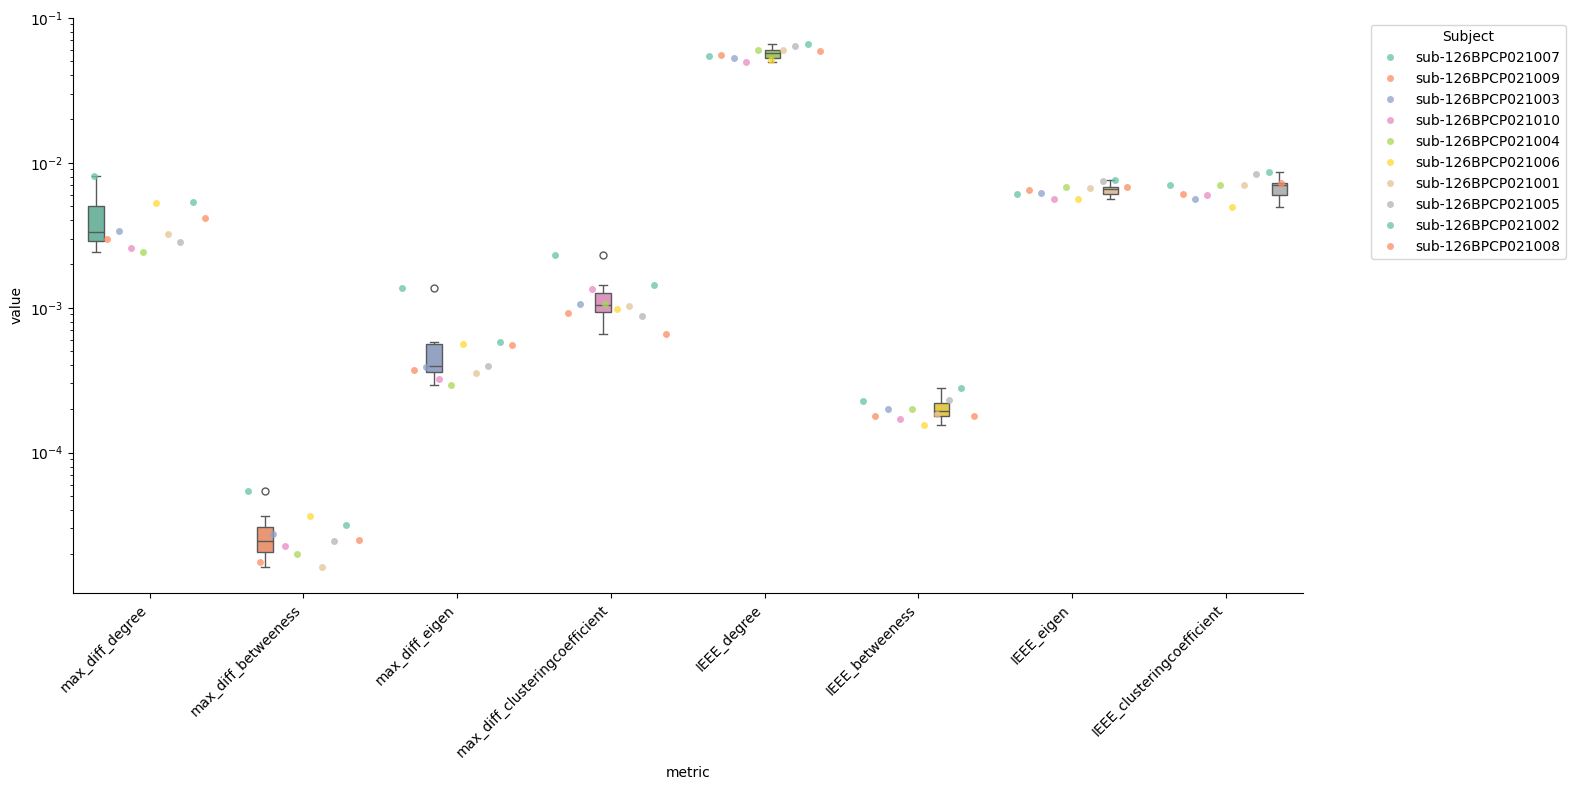

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Melt the DataFrame to long-form for seaborn
statics_melted = statics.melt(id_vars=['subject'], var_name='metric', value_name='value')

# Create the boxplot and swarmplot using seaborn.catplot
g = sns.catplot(
    data=statics_melted, kind="box", x='metric', y='value',
    palette="Set2", height=8, aspect=2, dodge=True  # Adjust the height and aspect ratio
)

# Overlay the swarmplot on the boxplot
sns.swarmplot(
    data=statics_melted, x='metric', y='value',  hue='subject',
    palette="Set2", dodge=True, alpha=0.75, ax=g.ax
)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust the legend position
g.ax.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
g.set(yscale="log")

# Use tight_layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
fslstats_hmc_values=pd.read_csv('/home/mina94/scratch/fixSeed_threads/eval_SSD_hmc/fslstats_hmc_values.csv')
fslstats_N4bias_values=pd.read_csv('/home/mina94/scratch/fixSeed_threads/eval_SSD_N4bias/fslstats_N4bias_values.csv')
fslstats=pd.DataFrame()
fslstats['hmc']=fslstats_hmc_values['Sum_of_squared_differences']
fslstats['N4bias']=fslstats_N4bias_values['Sum_of_squared_differences']


/tmp/ipykernel_1524691/2937359625.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_1524691/2937359625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/home/mina94/scratch/fixSeed_threads/myenv2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 81.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mina94/scratch/fixSeed_threads/myenv2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artis

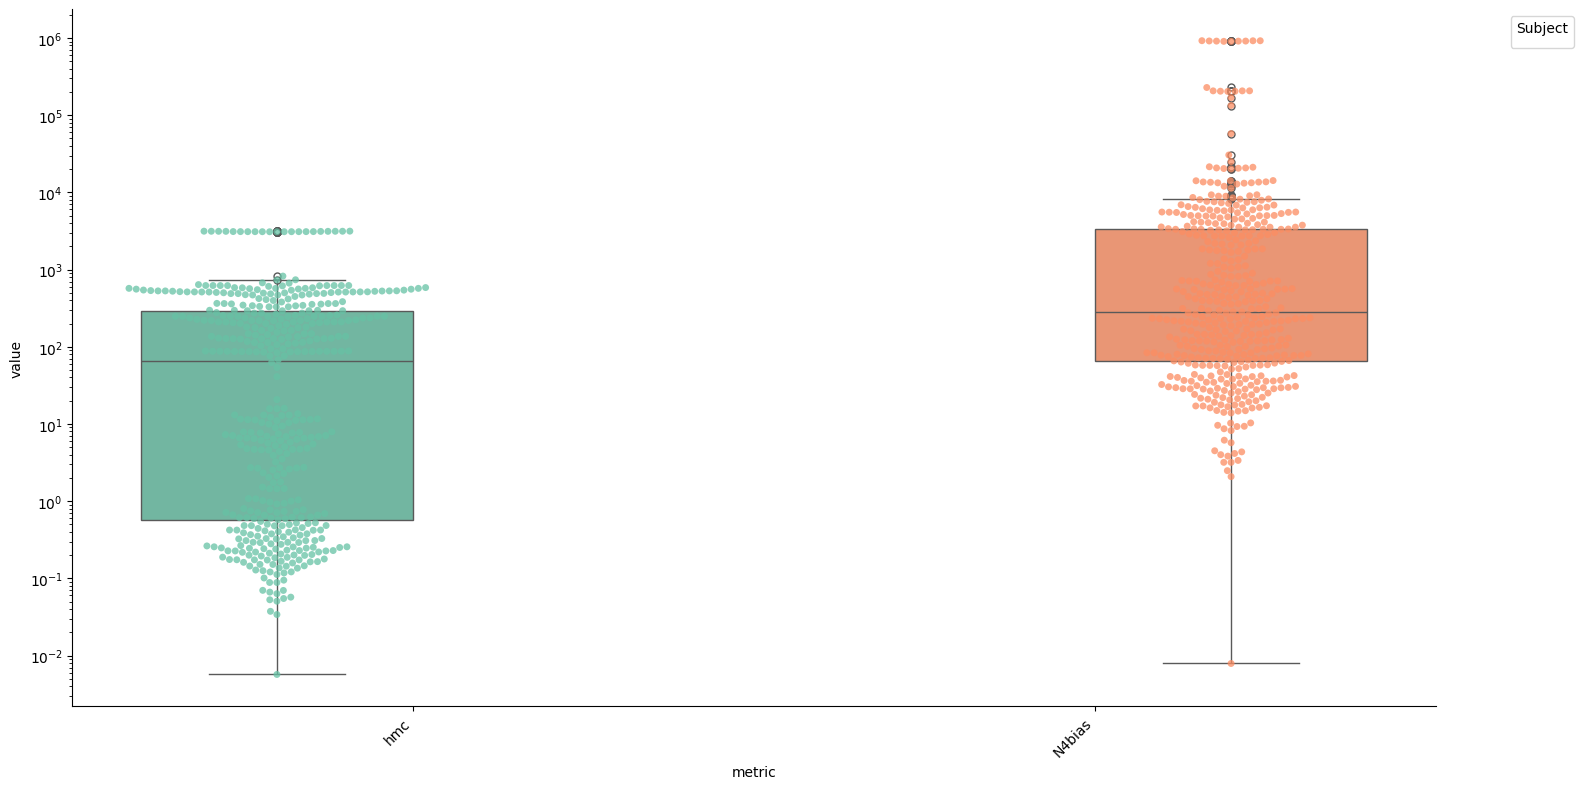

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CSV data
fslstats_hmc_values = pd.read_csv('/home/mina94/scratch/fixSeed_threads/eval_SSD_hmc/fslstats_hmc_values.csv')
fslstats_N4bias_values = pd.read_csv('/home/mina94/scratch/fixSeed_threads/eval_SSD_N4bias/fslstats_N4bias_values.csv')

# Create a new DataFrame combining the relevant columns
fslstats = pd.DataFrame()
fslstats['hmc'] = fslstats_hmc_values['Sum_of_squared_differences']
fslstats['N4bias'] = fslstats_N4bias_values['Sum_of_squared_differences']

# Melt the DataFrame to long-form for seaborn plotting
fslstats_melted = fslstats.melt(var_name='metric', value_name='value')

# Create the boxplot and swarmplot using seaborn.catplot
g = sns.catplot(
    data=fslstats_melted, kind="box", x='metric', y='value',
    palette="Set2", height=8, aspect=2, dodge=True  # Adjust the height and aspect ratio
)

# Overlay the swarmplot on the boxplot
sns.swarmplot(
    data=fslstats_melted, x='metric', y='value',
    palette="Set2", dodge=True, alpha=0.75, ax=g.ax
)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Adjust the legend position
g.ax.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
g.set(yscale="log")

# Use tight_layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


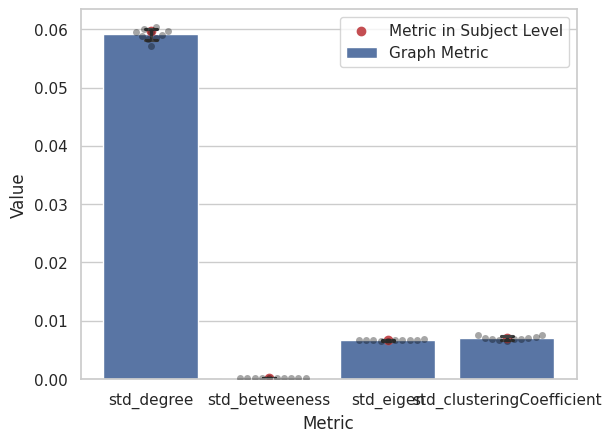

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(0)
# Convert IEEE_metric to DataFrame
IEEE_df = pd.DataFrame.from_dict(IEEE_metric['sub-126BPCP021001']['std_metric'], orient='index', columns=['Value']).reset_index()
IEEE_df = IEEE_df.rename(columns={'index': 'Metric'})

# Convert subdict_ses1 to DataFrame and melt
MCA_df = pd.DataFrame(subdict_ses1['sub-126BPCP021001']['std_metric'])
MCA_long_df = pd.melt(MCA_df, var_name='Metric', value_name='Value')

# Create the bar plot with standard deviation caps
sns.barplot(x="Metric", y="Value", data=MCA_long_df, capsize=.1, errorbar="sd", label="Graph Metric")

# Overlay the swarm plot with individual data points
sns.swarmplot(x="Metric", y="Value", data=MCA_long_df, color="0", alpha=.35)

# Plot the IEEE metric data
plt.scatter(IEEE_df['Metric'], IEEE_df['Value'], marker='o', color='r', label='Metric in Subject Level')

# Add labels and legend
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend()

In [29]:
subdict_ses1[]

TypeError: unhashable type: 'slice'

In [33]:
df_IEEE_metric=pd.DataFrame.from_dict(IEEE_metric['sub-126BPCP021007']['std_metric'])
df_IEEE_metric

ValueError: If using all scalar values, you must pass an index

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.subplots as sp
import numpy as np
from scipy.stats import norm

# Example data structure similar to df_sd_dic
np.random.seed(42)  # For reproducibility

# Initialize Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Histograms of Keys for iteration of one subject"),
    dcc.Dropdown(
        id='subject-dropdown',
        options=[{'label': metrics, 'value': metrics} for subject in iter_dict['graph_metrics'].keys()],
        multi=True,  # Allow multiple selection
        value=list(iter_dict['graph_metrics'].keys()),  # Default value: All subjects selected
        style={'width': '50%'}
    ),
    dcc.Graph(id='histogram-plot')
])

# Callback to update the plot based on selected subjects
@app.callback(
    Output('histogram-plot', 'figure'),
    [Input('subject-dropdown', 'value')]
)
def update_plot(selected_subjects):
    # Create subplots with shared x-axis
    fig = sp.make_subplots(rows=2, cols=3, subplot_titles=['degree_centralities', 'betweenness_centralities', 'eigenvector_centralities', 'clustering_coefficients', 'shortest_path_lengths', 'small_worldness'], shared_yaxes=True, shared_xaxes='rows',
                           row_heights=[0.4, 0.4])

    # Loop through the selected subjects and add histograms
    for i, key in enumerate(['degree_centralities', 'betweenness_centralities', 'eigenvector_centralities', 'clustering_coefficients', 'shortest_path_lengths', 'small_worldness'], start=1):
        for subject in selected_subjects:
            # Add histogram for each selected subject
            fig.add_trace(go.Histogram(x=iter_dict['graph_metrics'][subject][key], name=f'{subject} - {key}'), row=(i-1)//3 + 1, col=(i-1)%3 + 1, )
            # x_curve = np.linspace(min(df_sd_dic[subject][key]), max(df_sd_dic[subject][key]), 100)
            # y_curve = norm.pdf(x_curve, loc=np.mean(df_sd_dic[subject][key]), scale=np.std(df_sd_dic[subject][key]))
            # fig.add_trace(go.Scatter(x=x_curve, y=y_curve, mode='lines', name=f'Normal Curve - {subject} - {key}'), row=(i-1)//3 + 1, col=(i-1)%3 + 1)

    # Update layout for better readability
    fig.update_layout(
        title_text=f'Histograms of graph metrics for Subjects',
        # xaxis_title='standard deviation',
        height=800,  # Adjust the height of the entire figure
    )
    fig.update_xaxes(tickformat='e', exponentformat='e', showticksuffix='none', ticksuffix='e+0')


    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)



